In [1]:
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import contextily as cx
import fiona

# Potentiel solaire package
from potentiel_solaire.constants import DATA_FOLDER

In [2]:
# Executer ci dessous ci besoin pour récupérer les données
# !extract-sample-data
# Et pour sauver une version markdown des notebooks, utiliser
# jupyter nbconvert donnees_par_ecole.ipynb --to markdown --output-dir=exports/

In [5]:
src = DATA_FOLDER / "saint_denis_reference_data.gpkg"
layers = fiona.listlayers(src)

for layer in layers:
    gdf = gpd.read_file(src, layer=layer)
    print(f"* Couche: {layer} avec {len(gdf)} éléments.")

* Couche: annuaire_education avec 88 éléments.
* Couche: annuaire_education_sans_zone avec 24 éléments.
* Couche: bdtopo_education avec 49 éléments.
* Couche: bdtopo_batiment avec 437 éléments.
* Couche: cadastre_parcellaire avec 477 éléments.
* Couche: potentielsolaire_bati avec 496 éléments.
* Couche: potentielsolaire_toitures avec 357 éléments.
* Couche: identifiers avec 88 éléments.


In [73]:
zones = gpd.read_file(src, layer="bdtopo_education")
ecoles = gpd.read_file(src, layer="annuaire_education")
ecoles_seules = gpd.read_file(src, layer="annuaire_education_sans_zone") 
potentiel = gpd.read_file(src, layer="potentielsolaire_toitures")
batiments_ecoles = gpd.read_file(src, layer="bdtopo_batiment")

/tmp/ipykernel_281035/4027241553.py:9: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax1.legend()


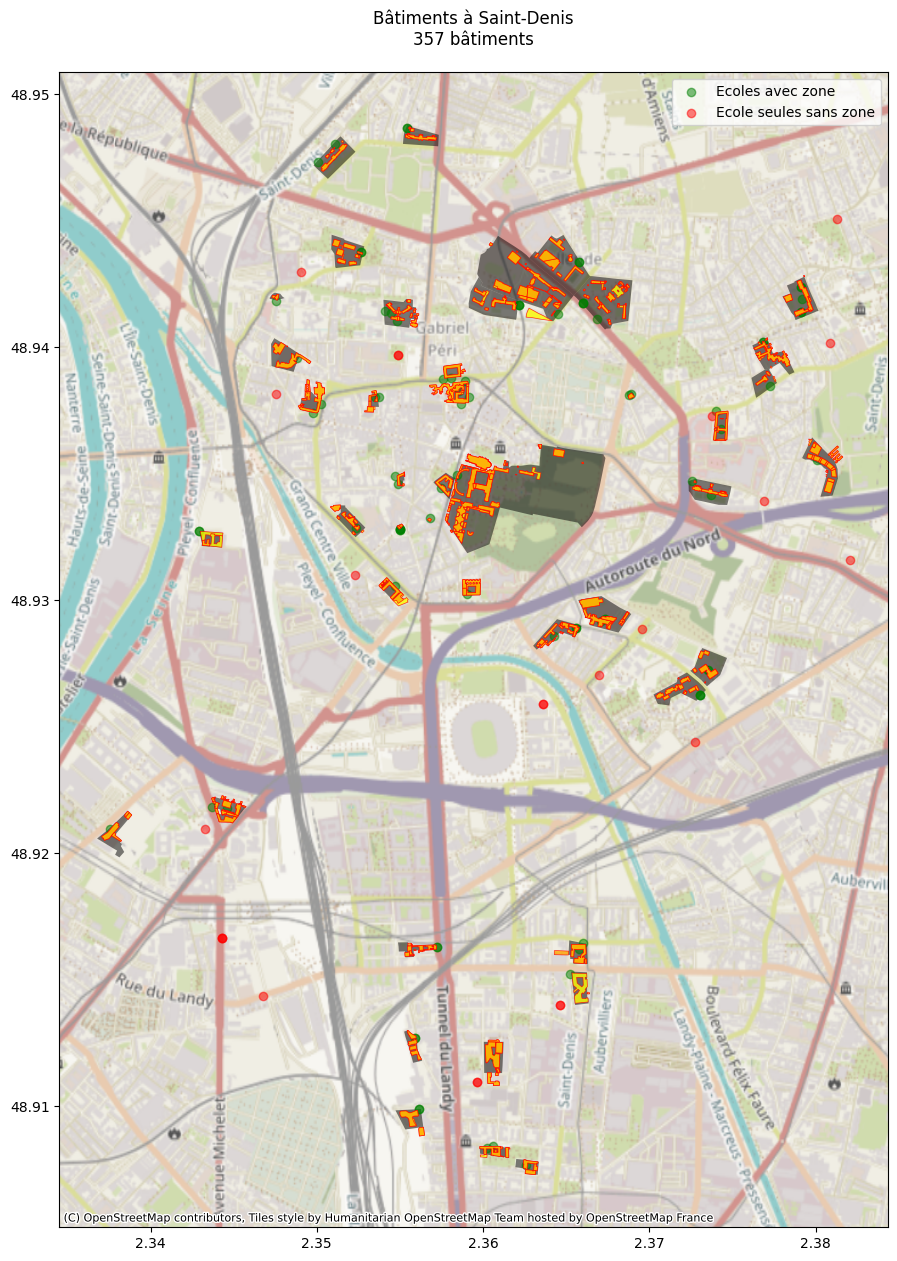

In [75]:
fig1, ax1 = plt.subplots(figsize=(15, 15))
zones.plot(ax=ax1, color='black', alpha=0.5, label='Zones')
ecoles.plot(ax=ax1, color='green', alpha=0.5, label='Ecoles avec zone')
ecoles_seules.plot(ax=ax1, color='red', alpha=0.5, label='Ecole seules sans zone')
batiments_ecoles.plot(ax=ax1, facecolor='yellow', edgecolor='red', linewidth=0.5, alpha=0.8, label='Saint-Denis')
potentiel.plot(ax=ax1, facecolor='orange', edgecolor='red', linewidth=0.5, alpha=0.8, label='Saint-Denis')
cx.add_basemap(ax1, crs=zones.crs, zoom=14)
ax1.set_title(f"Bâtiments à Saint-Denis\n{len(potentiel)} bâtiments", pad=20)
ax1.legend()
plt.show()

# Premiere estimation

France: 1000 kWh/m2/an  à 1900 kWh/m2/an

In [132]:
gdf = potentiel

gdb = batiments_ecoles

In [133]:
batiments_calcules = gdf[list(gdf.columns)[:18]+["geometry"]]
batiments_calcules = batiments_calcules.rename(columns={"id": "cleabs"})
batiments_reference = gdb
batiments_reference = batiments_reference.rename(columns={"cleabs_left__bat": "cleabs"})
communs = list(set(batiments_calcules.cleabs) & set(batiments_reference.cleabs))
batiments_reference = batiments_reference[batiments_reference.cleabs.isin(communs)]
batiments_calcules = batiments_calcules[batiments_calcules.cleabs.isin(communs)]


# On calcule les surfaces
batiments_calcules = batiments_calcules.to_crs(epsg=6933)
batiments_calcules["surface_calculee"] = batiments_calcules.area
batiments_calcules = batiments_calcules.to_crs(epsg=4326)

batiments_reference = batiments_reference.to_crs(epsg=6933)
batiments_reference["surface_calculee"] = batiments_reference.area
batiments_reference = batiments_reference.to_crs(epsg=4326)

In [135]:
batiments_calcules["calcul_naif"] = 1100*batiments_calcules["surface_calculee"]

In [136]:
batiments_calcules = batiments_calcules[["surface_calculee", "surf_util", "production", "calcul_naif","moyenne2", "indic2","forme",  "gisement"	,"eq_pano",	"eq_surf"	,"cleabs", "geometry"]]
test = batiments_calcules[batiments_calcules.surf_util > 0]
test["ratio"] = test["production"] / test["calcul_naif"]
ratio = test["ratio"].mean()
batiments_calcules["calcul_naif"] = 1100*batiments_calcules["surface_calculee"]
batiments_calcules["calcul_naif_maj"] = 1100*batiments_calcules["surface_calculee"]*ratio
batiments_calcules

/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,surface_calculee,surf_util,production,calcul_naif,moyenne2,indic2,forme,gisement,eq_pano,eq_surf,cleabs,geometry,calcul_naif_maj
0,3182.864620,1944.00,213541.062838,3.501151e+06,1205.511696,3,plat,important,plus de 50 panneaux,plus de 115 m2,BATIMENT0000000318256828,"POLYGON ((2.36719 48.93004, 2.36696 48.93002, ...",153562.836115
1,4253.467615,810.00,90874.379954,4.678814e+06,1231.240041,3,plat,important,plus de 50 panneaux,plus de 115 m2,BATIMENT0000000243404073,"POLYGON ((2.36013 48.91242, 2.36015 48.91213, ...",205215.938582
2,128.561045,2.25,0.000000,1.414171e+05,NaN,-1,Npans,Non favorable,Non favorable,Non favorable,BATIMENT0000000229477227,"POLYGON ((2.35275 48.94371, 2.35246 48.94377, ...",6202.651070
3,3146.850632,936.00,104887.667195,3.461536e+06,1229.801070,3,plat,important,plus de 50 panneaux,plus de 115 m2,BATIMENT0000000002629660,"POLYGON ((2.34956 48.93933, 2.34964 48.93942, ...",151825.278652
4,552.109173,162.00,22486.547854,6.073201e+05,1134.034730,3,toit2pentes,important,plus de 50 panneaux,plus de 115 m2,BATIMENT0000000229478106,"POLYGON ((2.38134 48.93547, 2.38129 48.93551, ...",26637.466764
...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,20.386765,6.75,1016.122389,2.242544e+04,1229.874593,1,petit_toit,faible,2 à 9 panneaux,entre 4.5 et 20 m2,BATIMENT0000000243407957,"POLYGON ((2.36258 48.9433, 2.36253 48.94327, 2...",983.594895
350,31.507794,6.75,959.893115,3.465857e+04,1161.816890,1,petit_toit,faible,2 à 9 panneaux,entre 4.5 et 20 m2,BATIMENT0000000243408047,"POLYGON ((2.36454 48.94175, 2.36454 48.94174, ...",1520.148276
351,21.832447,0.00,0.000000,2.401569e+04,NaN,-1,petit_toit,Non favorable,Non favorable,Non favorable,BATIMENT0000000243404353,"POLYGON ((2.37179 48.92651, 2.37176 48.9265, 2...",1053.344335
355,782.855874,483.75,52563.953253,8.611415e+05,1192.486116,3,plat,important,plus de 50 panneaux,plus de 115 m2,BATIMENT0000000353683846,"POLYGON ((2.36253 48.90733, 2.36314 48.90729, ...",37770.242428


<Axes: title={'center': 'Relation between production et surface calculée\nloglog scale'}, xlabel='surface_calculee', ylabel='production'>

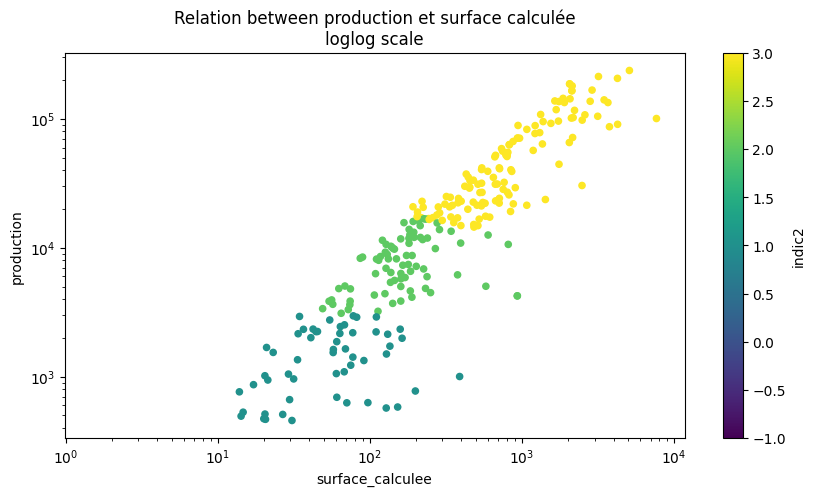

In [151]:
batiments_calcules.plot.scatter(x="surface_calculee",y="production",c="indic2",colormap='viridis',\
    title='Relation between production et surface calculée\nloglog scale', \
    logx=True, logy=True,
    figsize = (10,5))

<Axes: title={'center': 'Relation between surface calculée et surface utile\nloglog scale'}, xlabel='surface_calculee', ylabel='surf_util'>

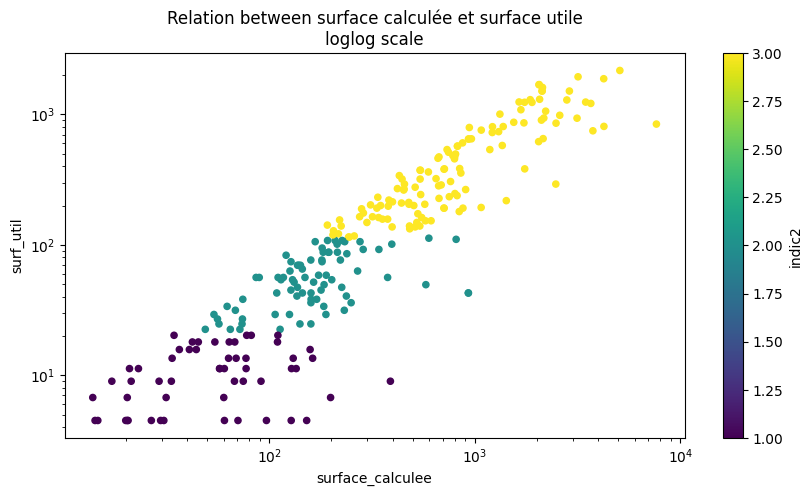

In [152]:
batiments_calcules[batiments_calcules.indic2 > 0].plot.scatter(x="surface_calculee",y="surf_util",c="indic2",colormap='viridis', \
    title='Relation between surface calculée et surface utile\nloglog scale', \
    logx=True, logy=True,
    figsize = (10,5))

<Axes: title={'center': 'Relation between naive estimation and actual production\nloglog scale'}, xlabel='production', ylabel='calcul_naif_maj'>

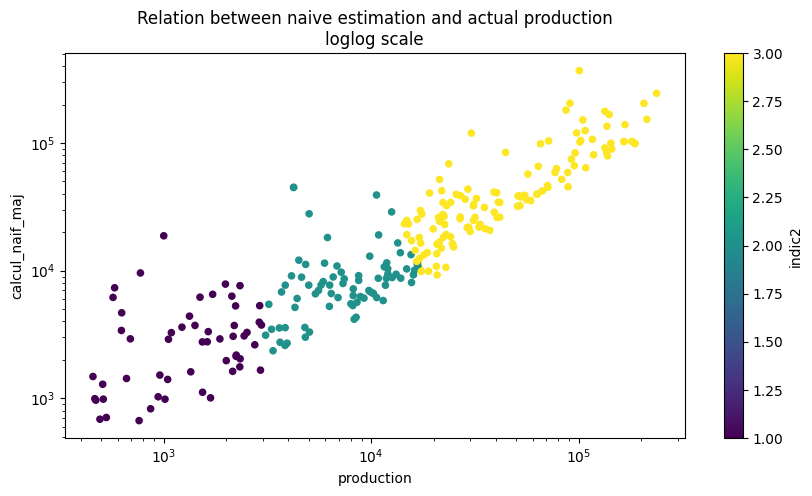

In [153]:
batiments_calcules[batiments_calcules.indic2 > 0].plot.scatter( \
    x="production",y="calcul_naif_maj",c="indic2",colormap='viridis', \
    title='Relation between naive estimation and actual production\nloglog scale', \
    logx=True, logy=True,
    figsize = (10,5))